In [1]:
import os

In [2]:
base_path = "C:\\Users\\johnn\\Desktop\\Repos\\Capstonfire"

# Improving the model - Adding more data

As we saw in the experiments with the first model, the main problems with the current model is that there are not enough different situations that allow the model to consider confounding images, e.g. clouds, as non fire images. We also saw that changing the optimizer to a more complex one (Adam) and decreasing the size of the images of the FIRE Dataset made the previsions worse.

This establishes the main objective for the next models:

- Train models with more images

For this, we will use the dataset that comprises the images of the FIRE dataset and of the Forest Fire dataset. We will then try training with the two datasets and The Wildfire Dataset and see how the model improves.

Since compressing the size of the images of the FIRE dataset made previsions worse, we will start by adding the original images to the composed datasets.

In [3]:
# We will call the FIRE + Forest Fire dataset the 3 F's dataset to make naming easier
fire_forest_fire_dataset_path = os.path.join(base_path, "new_fire_forest_fire_datasets")

In [4]:
three_f_fire_path = os.path.join(fire_forest_fire_dataset_path, "fire_images")
os.makedirs(three_f_fire_path, exist_ok=True)

three_f_non_fire_path = os.path.join(fire_forest_fire_dataset_path, "non_fire_images")
os.makedirs(three_f_non_fire_path)

In [5]:
import shutil

In [7]:
fire_dataset_fire_path = os.path.join(base_path, "FIRE Dataset", "fire_images")
for filename in os.listdir(fire_dataset_fire_path):
    shutil.copy2(os.path.join(fire_dataset_fire_path, filename), three_f_fire_path)

fire_dataset_non_fire_path = os.path.join(base_path, "FIRE Dataset", "non_fire_images")
for filename in os.listdir(fire_dataset_non_fire_path):
    shutil.copy2(os.path.join(fire_dataset_non_fire_path, filename), three_f_non_fire_path)

In [9]:
forest_fire_dataset_fire_path = os.path.join(base_path, "Forest Fire Dataset", "fire_images")
for filename in os.listdir(forest_fire_dataset_fire_path):
    shutil.copy2(os.path.join(forest_fire_dataset_fire_path, filename), three_f_fire_path)

forest_fire_dataset_non_fire_path = os.path.join(base_path, "Forest Fire Dataset", "non_fire_images")
for filename in os.listdir(forest_fire_dataset_non_fire_path):
    shutil.copy2(os.path.join(forest_fire_dataset_non_fire_path, filename), three_f_non_fire_path)

In [10]:
full_dataset_path = os.path.join(base_path, "new_full_dataset")

In [11]:
full_dataset_fire_path = os.path.join(full_dataset_path, "fire_images")
os.makedirs(full_dataset_fire_path, exist_ok=True)

full_dataset_non_fire_path = os.path.join(full_dataset_path, "non_fire_images")
os.makedirs(full_dataset_non_fire_path)

In [12]:
for filename in os.listdir(fire_dataset_fire_path):
    shutil.copy2(os.path.join(fire_dataset_fire_path, filename), full_dataset_fire_path)

for filename in os.listdir(fire_dataset_non_fire_path):
    shutil.copy2(os.path.join(fire_dataset_non_fire_path, filename), full_dataset_non_fire_path)

In [13]:
for filename in os.listdir(forest_fire_dataset_fire_path):
    shutil.copy2(os.path.join(forest_fire_dataset_fire_path, filename), full_dataset_fire_path)

for filename in os.listdir(forest_fire_dataset_non_fire_path):
    shutil.copy2(os.path.join(forest_fire_dataset_non_fire_path, filename), full_dataset_non_fire_path)

In [14]:
wildfire_dataset_fire_path = os.path.join(base_path, "wildfire_dataset", "fire_images")
for filename in os.listdir(wildfire_dataset_fire_path):
    shutil.copy2(os.path.join(wildfire_dataset_fire_path, filename), full_dataset_fire_path)

wildfire_dataset_non_fire_path = os.path.join(base_path, "wildfire_dataset", "non_fire_images")
for filename in os.listdir(wildfire_dataset_non_fire_path):
    shutil.copy2(os.path.join(wildfire_dataset_non_fire_path, filename), full_dataset_non_fire_path)

Done. The Wildfire Dataset is still compressed to save size and avoid having the model take too long to analyse large images.

Let's start training.

In [24]:
import os
from capstonfire_utils import plot_loss, plot_accuracy, FireDataset, split_dataset_into_dataloaders, train_model, calculate_metrics, run_video

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchsummary

from torchviz import make_dot

base_path = "C:\\Users\\johnn\\Desktop\\Repos\\Capstonfire"
fire_forest_fire_dataset_path = os.path.join(base_path, "new_fire_forest_fire_datasets")

In [25]:
three_f_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [26]:
three_f_dataset = FireDataset(fire_forest_fire_dataset_path, three_f_transform)

In [27]:
three_f_train_loader, three_f_val_loader, three_f_test_loader = split_dataset_into_dataloaders(three_f_dataset, 50, 0.7, 0.2, 0.1)

In [28]:
len(three_f_train_loader.dataset) + len(three_f_val_loader.dataset) + len(three_f_test_loader.dataset)

4218

In [29]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5) # to capture basic patterns from the image
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)# to capture basic patterns from the previous patterns (results in capturing more complex patterns from the original image)
        self.fc1 = nn.Linear(74420, 50)
        self.fc2 = nn.Linear(50, 2) # DNN > WNN; also 2 classes

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 74420)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #return F.log_softmax(x, dim=1)
        return x

three_f_model = SimpleCNN()

In [30]:
torchsummary.summary(model=three_f_model, input_size=(3, 256, 256), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 252, 252]             760
            Conv2d-2         [-1, 20, 122, 122]           5,020
            Linear-3                   [-1, 50]       3,721,050
            Linear-4                    [-1, 2]             102
Total params: 3,726,932
Trainable params: 3,726,932
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 7.12
Params size (MB): 14.22
Estimated Total Size (MB): 22.08
----------------------------------------------------------------


In [31]:
three_f_model_name = "dummy_cnn_two_datasets"

In [32]:
x = torch.randn(50, 3, 256, 256)  # A dummy input tensor to pass through the model
y = three_f_model(x)

dot = make_dot(y, params=dict(list(three_f_model.named_parameters()) + [('x', x)]))
dot.render('model details/' + three_f_model_name + '-model_visualization', format='png')

'model details\\dummy_cnn_two_datasets-model_visualization.png'

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(three_f_model.parameters(), lr=0.0003, momentum=0.9)

In [34]:
three_f_history = train_model(three_f_model, criterion, optimizer, base_path, three_f_model_name, 20, three_f_train_loader, three_f_val_loader)

CUDA is available. Using GPU.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 0.6696, Train Accuracy: 0.5767, Validation Loss: 0.6584, Validation Accuracy: 0.5367
Epoch [2/20], Train Loss: 0.6102, Train Accuracy: 0.6295, Validation Loss: 0.5642, Validation Accuracy: 0.7287
Epoch [3/20], Train Loss: 0.5082, Train Accuracy: 0.7294, Validation Loss: 0.4660, Validation Accuracy: 0.7382
Epoch [4/20], Train Loss: 0.4330, Train Accuracy: 0.7867, Validation Loss: 0.4240, Validation Accuracy: 0.8128
Epoch [5/20], Train Loss: 0.3706, Train Accuracy: 0.8324, Validation Loss: 0.3310, Validation Accuracy: 0.8649
Epoch [6/20], Train Loss: 0.3352, Train Accuracy: 0.8517, Validation Loss: 0.2983, Validation Accuracy: 0.8827
Epoch [7/20], Train Loss: 0.3016, Train Accuracy: 0.8784, Validation Loss: 0.3276, Validation Accuracy: 0.8720
Epoch [8/20], Train Loss: 0.2741, Train Accuracy: 0.8886, Validation Loss: 0.2408, Validation Accuracy: 0.9147
Epoch [9/20], Train Loss: 0.2411, Train Accuracy: 0.9092, Validation Loss: 0.2151, Validation Accuracy: 0.9348
E

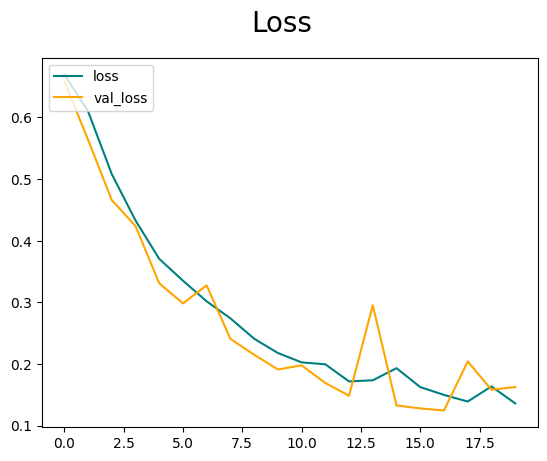

In [35]:
plot_loss(three_f_history["avg_train_loss_list"], three_f_history["avg_val_loss_list"])

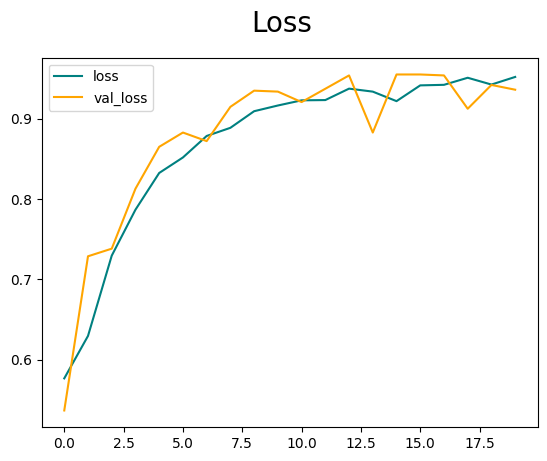

In [36]:
plot_accuracy(three_f_history["train_accuracy_list"], three_f_history["val_accuracy_list"])

In [37]:
custom_test_loader = DataLoader(FireDataset(os.path.join(base_path, "test dataset"), three_f_transform), 50, False)

calculate_metrics(three_f_model, custom_test_loader)

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

Recall on the test set: 0.63
Precision on the test set: 0.63
F1 Score on the test set: 0.63


Let's compare with the first model:

In [40]:
model_name = "dummy_cnn"
first_model = SimpleCNN()
first_history = train_model(first_model, criterion, optimizer, base_path, model_name, 20, three_f_train_loader, three_f_val_loader)

CUDA is available. Using GPU.


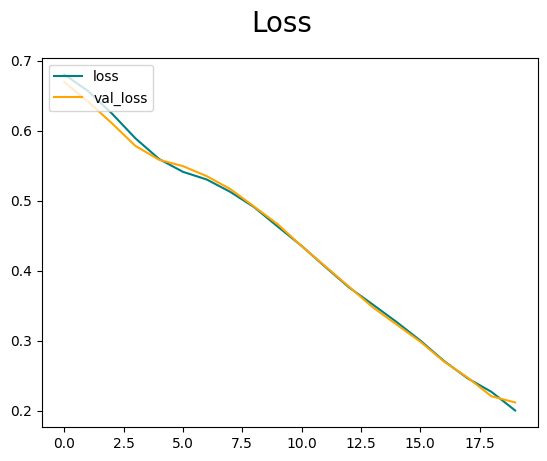

In [44]:
plot_loss(first_history["avg_train_loss_list"], first_history["avg_val_loss_list"])

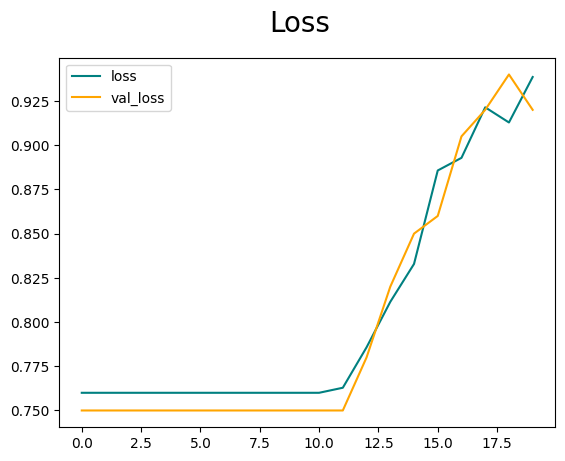

In [45]:
plot_accuracy(first_history["train_accuracy_list"], first_history["val_accuracy_list"])

In [43]:
calculate_metrics(first_model, custom_test_loader)

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

Recall on the test set: 0.75
Precision on the test set: 0.75
F1 Score on the test set: 0.75


Looks like it got worse. The loss is lower and the training/validation accuracy is better, which means that the model probaby overfitted. Let's train again but before the loss starts to stagnate, which was at about 12 epochs.

In [57]:
three_f_model_name = "dummy_cnn_two_datasets_12"
three_f_model_12 = SimpleCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(three_f_model_12.parameters(), lr=0.0003, momentum=0.9)

three_f_12_history = train_model(three_f_model_12, criterion, optimizer, base_path, three_f_model_name, 12, three_f_train_loader, three_f_val_loader)

CUDA is available. Using GPU.


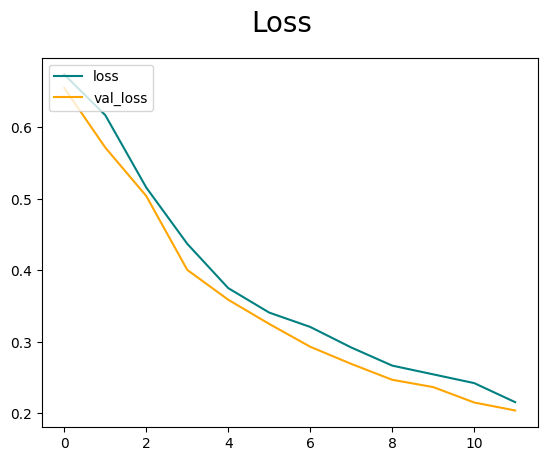

In [58]:
plot_loss(three_f_12_history["avg_train_loss_list"], three_f_12_history["avg_val_loss_list"])

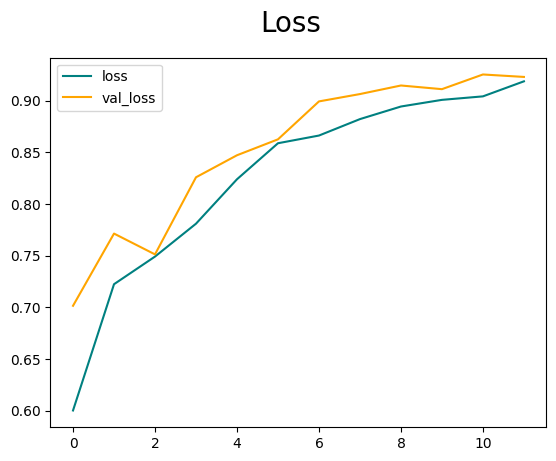

In [59]:
plot_accuracy(three_f_12_history["train_accuracy_list"], three_f_12_history["val_accuracy_list"])

In [60]:
calculate_metrics(three_f_model_12, custom_test_loader)

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

Recall on the test set: 0.47
Precision on the test set: 0.47
F1 Score on the test set: 0.47


Hmm wow, so the dataset did not overfit. But training more than 20 epochs seems like it would not make much of a difference. What if we train the first model with only the FIRE Dataset with more epochs, what would be the metrics then?

In [62]:
fire_dataset = FireDataset(os.path.join(base_path, "FIRE Dataset"), transforms=transforms.Compose([
                                                                        transforms.Resize((256, 256)),
                                                                        transforms.ToTensor()
                                                                    ])
)

fire_train_loader, fire_val_loader, fire_test_loader = split_dataset_into_dataloaders(fire_dataset, 50, 0.7, 0.2, 0.1)

model_name = "dummy_cnn_30"
first_model_30 = SimpleCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(first_model_30.parameters(), lr=0.0003, momentum=0.9)

first_history_30 = train_model(first_model_30, criterion, optimizer, base_path, model_name, 30, fire_train_loader, fire_val_loader)

CUDA is available. Using GPU.


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/30], Train Loss: 0.7280, Train Accuracy: 0.2414, Validation Loss: 0.6977, Validation Accuracy: 0.4000
Epoch [2/30], Train Loss: 0.6640, Train Accuracy: 0.6771, Validation Loss: 0.6173, Validation Accuracy: 0.7700
Epoch [3/30], Train Loss: 0.5976, Train Accuracy: 0.7586, Validation Loss: 0.5568, Validation Accuracy: 0.7700
Epoch [4/30], Train Loss: 0.5617, Train Accuracy: 0.7586, Validation Loss: 0.5406, Validation Accuracy: 0.7700
Epoch [5/30], Train Loss: 0.5467, Train Accuracy: 0.7586, Validation Loss: 0.5236, Validation Accuracy: 0.7700
Epoch [6/30], Train Loss: 0.5277, Train Accuracy: 0.7586, Validation Loss: 0.5049, Validation Accuracy: 0.7700
Epoch [7/30], Train Loss: 0.5040, Train Accuracy: 0.7586, Validation Loss: 0.4826, Validation Accuracy: 0.7700
Epoch [8/30], Train Loss: 0.4779, Train Accuracy: 0.7586, Validation Loss: 0.4569, Validation Accuracy: 0.7700
Epoch [9/30], Train Loss: 0.4466, Train Accuracy: 0.7586, Validation Loss: 0.4265, Validation Accuracy: 0.7700
E

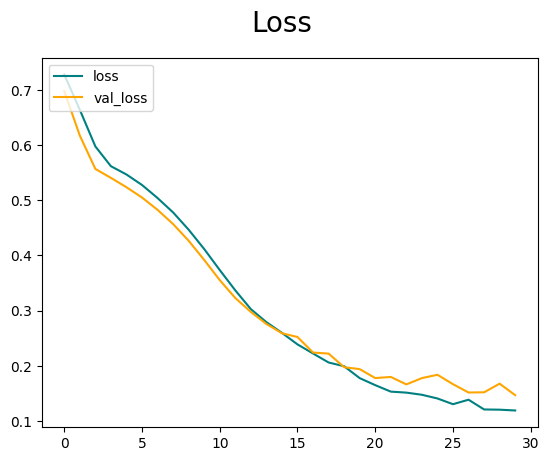

In [64]:
plot_loss(first_history_30["avg_train_loss_list"], first_history_30["avg_val_loss_list"])

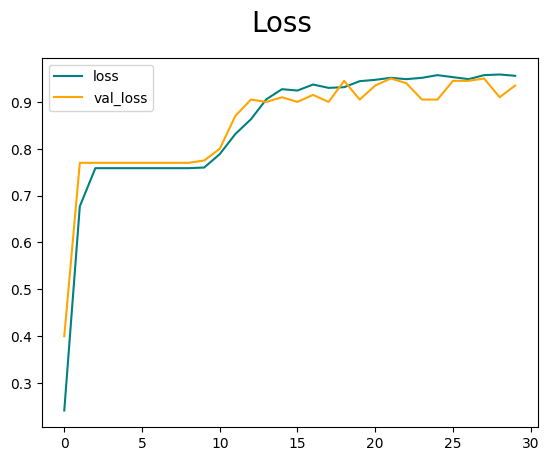

In [65]:
plot_accuracy(first_history_30["train_accuracy_list"], first_history_30["val_accuracy_list"])

In [63]:
calculate_metrics(first_model_30, custom_test_loader)

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

Recall on the test set: 0.70
Precision on the test set: 0.70
F1 Score on the test set: 0.70


Ah, it got worse, which means it overfitted. 20 epochs was conveniently the last epoch before validation loss increased for the first time, which seemed to be the best number of epochs for the FIRE Dataset. For the FIRE + Forest Fire dataset, that value seems to be 6 epochs. Let's train with this dataset with 6 epochs and see how it turns out.

In [67]:
three_f_model_name = "dummy_cnn_two_datasets_6"
three_f_model_6 = SimpleCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(three_f_model_6.parameters(), lr=0.0003, momentum=0.9)

three_f_6_history = train_model(three_f_model_6, criterion, optimizer, base_path, three_f_model_name, 6, three_f_train_loader, three_f_val_loader)

CUDA is available. Using GPU.


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/6], Train Loss: 0.6528, Train Accuracy: 0.6627, Validation Loss: 0.5818, Validation Accuracy: 0.7464
Epoch [2/6], Train Loss: 0.4946, Train Accuracy: 0.7589, Validation Loss: 0.4564, Validation Accuracy: 0.7915
Epoch [3/6], Train Loss: 0.4069, Train Accuracy: 0.7944, Validation Loss: 0.3691, Validation Accuracy: 0.8329
Epoch [4/6], Train Loss: 0.3529, Train Accuracy: 0.8405, Validation Loss: 0.3237, Validation Accuracy: 0.8744
Epoch [5/6], Train Loss: 0.3127, Train Accuracy: 0.8774, Validation Loss: 0.2974, Validation Accuracy: 0.8732
Epoch [6/6], Train Loss: 0.2789, Train Accuracy: 0.8950, Validation Loss: 0.4090, Validation Accuracy: 0.7855
Finished Training


In [68]:
calculate_metrics(three_f_model_6, custom_test_loader)

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

Recall on the test set: 0.43
Precision on the test set: 0.43
F1 Score on the test set: 0.43


Nope, looks like there is no real pattern. With some epochs it is better, with worse it is other. For the same number of epochs, for some datasets the model overfits while for other datasets it is fine. So far, 20 epochs has been the best value for the combined FIRE and Forest Fire Datasets, even though loss is much lower than for the FIRE Dataset. The loss does decrease much faster than with only the FIRE Dataset, probably because there are more similar images of fires, which allows the model to converge faster.

Might make sense to store models after some number of epochs, for example, every 5 epochs or every 2 epochs, to compare which number is the best. Let's do some changes to the training cycle function.

In [71]:
import json
from tqdm import tqdm
from tqdm.notebook import tqdm
from capstonfire_utils import plot_loss, plot_accuracy, FireDataset, split_dataset_into_dataloaders, calculate_metrics, run_video

In [154]:
def train_model(model: torch.nn.Module,criterion, optimizer, 
                models_folder_path: str, model_filename: str, 
                num_epochs: int, 
                train_loader: DataLoader, val_loader: DataLoader, 
                epoch_checkpoints: int = 0):
    

    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("CUDA is available. Using GPU.")
    else:
        device = torch.device("cpu")
        print("CUDA is not available. Using CPU.")

    if epoch_checkpoints < 1:
        print("Checkpoints smaller than 1. Only the final model will be saved.")

    model = model.to(device)

    history = {
        "avg_train_loss_list": [],
        "train_accuracy_list": [],
        "avg_val_loss_list": [],
        "val_accuracy_list": []
    }

    start_range = 0

    hist_file_path = os.path.join(models_folder_path, model_filename + '.json')
    
    # Retrieve model if it was already trained. The state loaded will be that of the last epoch.
    if model_filename + '.pt' in os.listdir(models_folder_path):
        model.load_state_dict(torch.load(os.path.join(models_folder_path, model_filename +'.pt')))
        
        with open(hist_file_path, 'r') as json_file:
            history = json.load(json_file)

        # If num_epochs is equal or lower to the epochs of a previously trained model, skip training. Else continue training
        if len(history["avg_train_loss_list"]) >= num_epochs:
            return history
        else:
            start_range = len(history["avg_train_loss_list"])

    # if model was never trained, enter loop. If asking for more epochs, start from where model was left off
    for epoch in tqdm(list(range(start_range, num_epochs))):
        model.train()

        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # zero the parameter gradients
            outputs = model(inputs)  # forward
            loss = criterion(outputs, labels)  # calculate loss
            loss.backward()  # backward
            optimizer.step()  # optimize

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
            
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            correct_val = 0
            total_val = 0
            val_loss = 0.0

            for inputs_val, labels_val in val_loader:
                inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
                outputs_val = model(inputs_val)
                loss_val = criterion(outputs_val, labels_val)

                _, predicted_val = torch.max(outputs_val, 1)
                total_val += labels_val.size(0)
                correct_val += (predicted_val == labels_val).sum().item()

                val_loss += loss_val.item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        history["avg_train_loss_list"].append(avg_train_loss)
        history["train_accuracy_list"].append(train_accuracy)
        history["avg_val_loss_list"].append(avg_val_loss)
        history["val_accuracy_list"].append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
            f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        
        # Do not save if there is no indication to store intermediate models or if it is the last iteration of the training loop
        if epoch_checkpoints < 1:
            continue

        # Store models after every epoch_checkpoints number of epochs
        if (epoch + 1) % epoch_checkpoints == 0 and epoch > 0:
            path_to_model_folder = os.path.join(models_folder_path, model_filename)

            if not os.path.exists(path_to_model_folder):
                os.makedirs(path_to_model_folder, exist_ok=True)
                
            torch.save(model.state_dict(), os.path.join(path_to_model_folder, "epoch_" + str(epoch + 1) + '.pt'))

    print('Finished Training')

    # save model at last epoch
    torch.save(model.state_dict(), os.path.join(models_folder_path, model_filename + '.pt'))

    # Write history dictionary to a JSON file
    with open(hist_file_path, 'w+') as json_file:
        json.dump(history, json_file)

    return history

Let's test this.

In [133]:
three_f_model_name = "dummy_cnn_two_datasets"
three_f_model = SimpleCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(three_f_model.parameters(), lr=0.0003, momentum=0.9)

three_f_history = train_model(three_f_model, criterion, optimizer, os.path.join(base_path, "trained_models"), three_f_model_name, 20, three_f_train_loader, three_f_val_loader, 2)

CUDA is available. Using GPU.


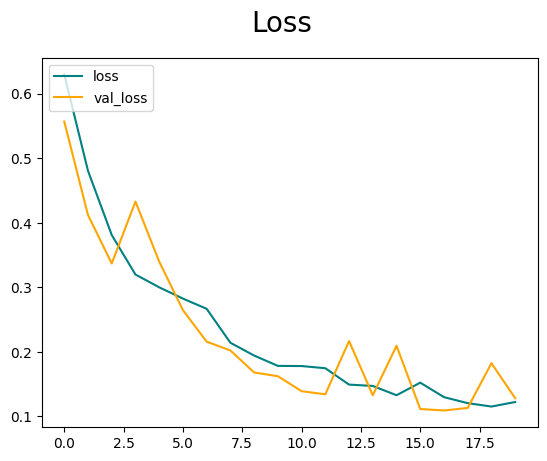

In [134]:
plot_loss(three_f_history["avg_train_loss_list"], three_f_history["avg_val_loss_list"])

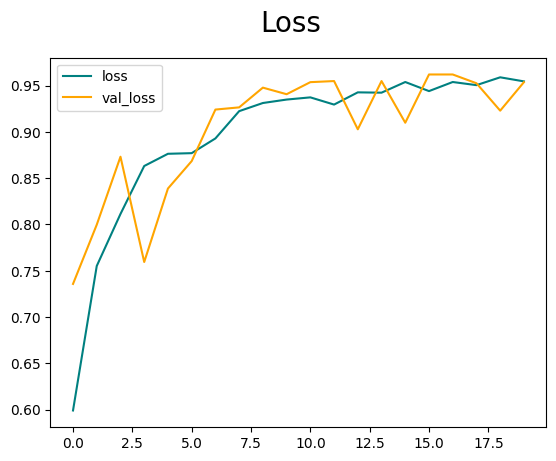

In [135]:
plot_accuracy(three_f_history["train_accuracy_list"], three_f_history["val_accuracy_list"])

In [108]:
from torchmetrics.classification import Precision, Recall, F1Score

In [131]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

intermediate_model = SimpleCNN().to(device)

epoch_metrics = {}

for dirpath, _, filenames in os.walk(os.path.join(base_path, "trained_models", three_f_model_name)):
    for model_filename in tqdm(filenames):
        intermediate_model.load_state_dict(torch.load(os.path.join(dirpath, model_filename)))
        print(model_filename + " metrics:")

        recall = Recall(task='multiclass',num_classes=2).to(device)
        precision = Precision(task='multiclass',num_classes=2).to(device)
        f1 = F1Score(task='multiclass',num_classes=2).to(device)

        with torch.no_grad():
            for data in custom_test_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = intermediate_model(inputs)  # forward
                #predicted_binary = (torch.sigmoid(outputs) > 0.5).float()
                predictions = torch.argmax(outputs, dim=1)

                recall.update(predictions, labels)
                precision.update(predictions, labels)
                f1.update(predictions, labels)

        precision_value = precision.compute()
        recall_value = recall.compute()
        f1_value = f1.compute()

        print('Precision/Recall/F1 Score')
        print('  %.2f     %.2f   %.2f'% (precision_value, recall_value, f1_value))

        epoch_metrics[model_filename] = {
            "Precision": precision_value, 
            "Recall": recall_value, 
            "F1Score": f1_value
            }

CUDA is available. Using GPU.


  0%|          | 0/9 [00:00<?, ?it/s]

epoch_10.pt metrics:


KeyboardInterrupt: 

In [116]:
calculate_metrics(three_f_model, custom_test_loader)

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

Recall on the test set: 0.53
Precision on the test set: 0.53
F1 Score on the test set: 0.53


Looks like the ideal number of epochs is not 6, 12 or 20, but somewhere between 16 and 18. Still, the metrics are worse than with just the FIRE Dataset.

Let's try 40 epochs and see how that turns out.

In [155]:
three_f_history = train_model(three_f_model, criterion, optimizer, os.path.join(base_path, "trained_models"), three_f_model_name, 40, three_f_train_loader, three_f_val_loader, 2)

CUDA is available. Using GPU.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [21/40], Train Loss: 0.1154, Train Accuracy: 0.9556, Validation Loss: 0.1054, Validation Accuracy: 0.9633
Epoch [22/40], Train Loss: 0.1169, Train Accuracy: 0.9621, Validation Loss: 0.1124, Validation Accuracy: 0.9621
Epoch [23/40], Train Loss: 0.1079, Train Accuracy: 0.9607, Validation Loss: 0.1151, Validation Accuracy: 0.9562
Epoch [24/40], Train Loss: 0.1077, Train Accuracy: 0.9611, Validation Loss: 0.1714, Validation Accuracy: 0.9254
Epoch [25/40], Train Loss: 0.1173, Train Accuracy: 0.9567, Validation Loss: 0.1295, Validation Accuracy: 0.9479
Epoch [26/40], Train Loss: 0.1014, Train Accuracy: 0.9634, Validation Loss: 0.1004, Validation Accuracy: 0.9668
Epoch [27/40], Train Loss: 0.0993, Train Accuracy: 0.9658, Validation Loss: 0.1342, Validation Accuracy: 0.9491
Epoch [28/40], Train Loss: 0.1165, Train Accuracy: 0.9580, Validation Loss: 0.1093, Validation Accuracy: 0.9645
Epoch [29/40], Train Loss: 0.1066, Train Accuracy: 0.9638, Validation Loss: 0.0968, Validation Accuracy:

In [156]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

intermediate_model = SimpleCNN().to(device)

epoch_metrics = {}

for dirpath, _, filenames in os.walk(os.path.join(base_path, "trained_models", three_f_model_name)):
    for model_filename in tqdm(filenames):
        intermediate_model.load_state_dict(torch.load(os.path.join(dirpath, model_filename)))
        print(model_filename + " metrics:")

        recall = Recall(task='multiclass',num_classes=2).to(device)
        precision = Precision(task='multiclass',num_classes=2).to(device)
        f1 = F1Score(task='multiclass',num_classes=2).to(device)

        with torch.no_grad():
            for data in custom_test_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = intermediate_model(inputs)  # forward
                #predicted_binary = (torch.sigmoid(outputs) > 0.5).float()
                predictions = torch.argmax(outputs, dim=1)

                recall.update(predictions, labels)
                precision.update(predictions, labels)
                f1.update(predictions, labels)

        precision_value = precision.compute()
        recall_value = recall.compute()
        f1_value = f1.compute()

        print('Precision/Recall/F1 Score')
        print('  %.2f     %.2f   %.2f'% (precision_value, recall_value, f1_value))

        epoch_metrics[model_filename] = {
            "Precision": precision_value, 
            "Recall": recall_value, 
            "F1Score": f1_value
            }

CUDA is available. Using GPU.


  0%|          | 0/19 [00:00<?, ?it/s]

epoch_10.pt metrics:
Precision/Recall/F1 Score
  0.51     0.51   0.51
epoch_12.pt metrics:
Precision/Recall/F1 Score
  0.56     0.56   0.56
epoch_14.pt metrics:
Precision/Recall/F1 Score
  0.52     0.52   0.52
epoch_16.pt metrics:
Precision/Recall/F1 Score
  0.59     0.59   0.59
epoch_18.pt metrics:
Precision/Recall/F1 Score
  0.59     0.59   0.59
epoch_2.pt metrics:
Precision/Recall/F1 Score
  0.35     0.35   0.35
epoch_22.pt metrics:
Precision/Recall/F1 Score
  0.55     0.55   0.55
epoch_24.pt metrics:
Precision/Recall/F1 Score
  0.54     0.54   0.54
epoch_26.pt metrics:
Precision/Recall/F1 Score
  0.57     0.57   0.57
epoch_28.pt metrics:
Precision/Recall/F1 Score
  0.55     0.55   0.55
epoch_30.pt metrics:
Precision/Recall/F1 Score
  0.55     0.55   0.55
epoch_32.pt metrics:
Precision/Recall/F1 Score
  0.53     0.53   0.53
epoch_34.pt metrics:
Precision/Recall/F1 Score
  0.60     0.60   0.60
epoch_36.pt metrics:
Precision/Recall/F1 Score
  0.59     0.59   0.59
epoch_38.pt metrics:


In [138]:
import pandas as pd

In [151]:
def sort_metrics(metrics_dict):
    df = pd.DataFrame.from_dict(metrics_dict, orient='index')
    df = df.map(lambda x: x.item() if isinstance(x, torch.Tensor) else x)
    df = df.rename(index=lambda x: int(x.split('_')[1].split('.')[0]))
    return df.sort_index()

In [157]:
sort_metrics(epoch_metrics)

,Precision,Recall,F1Score
2,0.345461,0.345461,0.345461
4,0.420227,0.420227,0.420227
6,0.462283,0.462283,0.462283
8,0.477303,0.477303,0.477303
10,0.510013,0.510013,0.510013
12,0.557076,0.557076,0.557076
14,0.522363,0.522363,0.522363
16,0.586115,0.586115,0.586115
18,0.594459,0.594459,0.594459
22,0.551402,0.551402,0.551402


The max seems to be at 38 epochs, however it is just an improvement of 3% over epoch 18. Not to mention it is still a lot worse than the model with just the FIRE Dataset. Not worth using it for anything.

Let's now add the third dataset and see how things turn out.

In [158]:
full_dataset_path = os.path.join(base_path, "new_full_dataset")

In [159]:
full_dataset = FireDataset(full_dataset_path, transforms=transforms.Compose([
                                                                        transforms.Resize((256, 256)),
                                                                        transforms.ToTensor()
                                                                    ])
)

full_train_loader, full_val_loader, full_test_loader = split_dataset_into_dataloaders(full_dataset, 50, 0.7, 0.2, 0.1)

In [160]:
full_model_name = "dummy_cnn_full_dataset"
full_model = SimpleCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(full_model.parameters(), lr=0.0003, momentum=0.9)

three_f_history = train_model(full_model, criterion, optimizer, os.path.join(base_path, "trained_models"), full_model_name, 40, full_train_loader, full_val_loader, 2)

CUDA is available. Using GPU.


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1/40], Train Loss: 0.6524, Train Accuracy: 0.6406, Validation Loss: 0.6233, Validation Accuracy: 0.6597
Epoch [2/40], Train Loss: 0.5852, Train Accuracy: 0.6747, Validation Loss: 0.5698, Validation Accuracy: 0.6712
Epoch [3/40], Train Loss: 0.5567, Train Accuracy: 0.6931, Validation Loss: 0.5508, Validation Accuracy: 0.6922
Epoch [4/40], Train Loss: 0.5344, Train Accuracy: 0.7193, Validation Loss: 0.5301, Validation Accuracy: 0.7305
Epoch [5/40], Train Loss: 0.5195, Train Accuracy: 0.7214, Validation Loss: 0.5505, Validation Accuracy: 0.6749
Epoch [6/40], Train Loss: 0.4955, Train Accuracy: 0.7464, Validation Loss: 0.4918, Validation Accuracy: 0.7796
Epoch [7/40], Train Loss: 0.4809, Train Accuracy: 0.7565, Validation Loss: 0.4718, Validation Accuracy: 0.7832
Epoch [8/40], Train Loss: 0.4722, Train Accuracy: 0.7691, Validation Loss: 0.4515, Validation Accuracy: 0.7955
Epoch [9/40], Train Loss: 0.4514, Train Accuracy: 0.7819, Validation Loss: 0.4602, Validation Accuracy: 0.7478
E

In [164]:
def calculate_epoch_metrics(models_path, model_name, test_loader):
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("CUDA is available. Using GPU.")
    else:
        device = torch.device("cpu")
        print("CUDA is not available. Using CPU.")

    intermediate_model = SimpleCNN().to(device)

    epoch_metrics = {}

    for dirpath, _, filenames in os.walk(os.path.join(models_path, model_name)):
        for model_filename in tqdm(filenames):
            intermediate_model.load_state_dict(torch.load(os.path.join(dirpath, model_filename)))
            print(model_filename + " metrics:")

            recall = Recall(task='multiclass',num_classes=2).to(device)
            precision = Precision(task='multiclass',num_classes=2).to(device)
            f1 = F1Score(task='multiclass',num_classes=2).to(device)

            with torch.no_grad():
                for data in test_loader:
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = intermediate_model(inputs)  # forward
                    #predicted_binary = (torch.sigmoid(outputs) > 0.5).float()
                    predictions = torch.argmax(outputs, dim=1)

                    recall.update(predictions, labels)
                    precision.update(predictions, labels)
                    f1.update(predictions, labels)

            precision_value = precision.compute()
            recall_value = recall.compute()
            f1_value = f1.compute()

            print('Precision/Recall/F1 Score')
            print('  %.2f     %.2f   %.2f'% (precision_value, recall_value, f1_value))

            epoch_metrics[model_filename] = {
                "Precision": precision_value, 
                "Recall": recall_value, 
                "F1Score": f1_value
                }
    
    return epoch_metrics

In [165]:
full_epoch_metrics = calculate_epoch_metrics(os.path.join(base_path, "trained_models"), full_model_name, custom_test_loader)
sort_metrics(full_epoch_metrics)

CUDA is available. Using GPU.


  0%|          | 0/20 [00:00<?, ?it/s]

epoch_10.pt metrics:
Precision/Recall/F1 Score
  0.75     0.75   0.75
epoch_12.pt metrics:
Precision/Recall/F1 Score
  0.76     0.76   0.76
epoch_14.pt metrics:
Precision/Recall/F1 Score
  0.73     0.73   0.73
epoch_16.pt metrics:
Precision/Recall/F1 Score
  0.74     0.74   0.74
epoch_18.pt metrics:
Precision/Recall/F1 Score
  0.75     0.75   0.75
epoch_2.pt metrics:
Precision/Recall/F1 Score
  0.50     0.50   0.50
epoch_20.pt metrics:
Precision/Recall/F1 Score
  0.76     0.76   0.76
epoch_22.pt metrics:
Precision/Recall/F1 Score
  0.75     0.75   0.75
epoch_24.pt metrics:
Precision/Recall/F1 Score
  0.80     0.80   0.80
epoch_26.pt metrics:
Precision/Recall/F1 Score
  0.77     0.77   0.77
epoch_28.pt metrics:
Precision/Recall/F1 Score
  0.77     0.77   0.77
epoch_30.pt metrics:
Precision/Recall/F1 Score
  0.75     0.75   0.75
epoch_32.pt metrics:
Precision/Recall/F1 Score
  0.79     0.79   0.79
epoch_34.pt metrics:
Precision/Recall/F1 Score
  0.71     0.71   0.71
epoch_36.pt metrics:


,Precision,Recall,F1Score
2,0.497330,0.497330,0.497330
4,0.663885,0.663885,0.663885
6,0.713618,0.713618,0.713618
8,0.742991,0.742991,0.742991
10,0.745995,0.745995,0.745995
12,0.758678,0.758678,0.758678
14,0.732977,0.732977,0.732977
16,0.735648,0.735648,0.735648
18,0.748665,0.748665,0.748665
20,0.760681,0.760681,0.760681


In [167]:
full_epoch_metrics_sorted = sort_metrics(full_epoch_metrics)
full_epoch_metrics_sorted.loc[full_epoch_metrics_sorted['Precision'].idxmax()]

Precision    0.803071
Recall       0.803071
F1Score      0.803071
Name: 24, dtype: float64

Looks like at 24 epochs the model got 5% better than our model that was only trained with the first dataset.

Let's store this model and test it on the videos.

In [170]:
full_model_best = SimpleCNN()
full_model_best.load_state_dict(torch.load(os.path.join(base_path, "trained_models", full_model_name, "epoch_24.pt")))

<All keys matched successfully>

In [171]:
import random
from collections import Counter

In [172]:
videos_folder = os.path.join(base_path, "test dataset videos")

In [173]:
transform_video = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x.to(device))
])

In [223]:
random_number = random.randint(0, 19)
random_odd_number = random_number + 1 if random_number % 2 == 0 else random_number
example_video = os.path.join(videos_folder, os.listdir(videos_folder)[random_odd_number])
example_video

'C:\\Users\\johnn\\Desktop\\Repos\\Capstonfire\\test dataset videos\\storm_timelapse.mp4'

In [224]:
predictions = run_video(example_video, full_model_best, transform_video)
predictions

{'fire': 0.37625289128758677, 'non_fire': 0.6229760986892829}

In [230]:
fetched_video_image_folder = os.path.join(example_video[0:-4])
fetched_video_dataset = FireDataset(fetched_video_image_folder, transforms=three_f_transform)

video_labels = [label for _, label in fetched_video_dataset.data]
full_model = full_model.to("cpu")
# Calculate the total number of labels
total_video_images = len(video_labels)

fire_count = 0
non_fire_count = 0

with torch.no_grad():
    for data in tqdm(fetched_video_dataset):
        inputs, labels = data
        outputs = full_model_best(inputs)  # forward
        #predicted_binary = (torch.sigmoid(outputs) > 0.5).float()
        current_prediction = torch.argmax(outputs, dim=1)

        # Count occurrences of 0 and 1 in predictions
        fire_count += torch.sum(current_prediction == 0).item()
        non_fire_count += torch.sum(current_prediction == 1).item()

print(predictions)
print({'fire': fire_count/total_video_images, 'non_fire': non_fire_count/total_video_images})

  0%|          | 0/233 [00:00<?, ?it/s]

{'fire': 0.37625289128758677, 'non_fire': 0.6229760986892829}
{'fire': 0.6437768240343348, 'non_fire': 0.3562231759656652}


In [236]:
fetched_video_image_folder = os.path.join(example_video[0:-4])
video_predictions = pd.DataFrame(columns=['video_name', '%_actual_fire_images', '%_actual_non_fire_images', '%_predicted_fire_images', '%_predicted_non_fire_images', '%_correct'])
full_model_best = full_model_best.to('cpu')

for folder in tqdm(os.listdir(videos_folder)):
    if "." in folder:
        continue

    folder_dataset = FireDataset(os.path.join(videos_folder, folder), transforms=three_f_transform)

    print(folder)
    video_labels = {0: 0, 1: 0}
    for class_name, count in Counter([label for _, label in folder_dataset.data]).items():
        video_labels[class_name] = count 

    total_video_images = video_labels[0] + video_labels[1]

    fire_count = 0
    non_fire_count = 0
    is_correct = 0

    with torch.no_grad():
        for data in folder_dataset:
            input, label = data
            outputs = full_model_best(input)  # forward
            #predicted_binary = (torch.sigmoid(outputs) > 0.5).float()
            current_prediction = torch.argmax(outputs, dim=1)

            # Count occurrences of 0 and 1 in predictions
            fire_count += torch.sum(current_prediction == 0).item()
            non_fire_count += torch.sum(current_prediction == 1).item()
            is_correct += torch.sum(current_prediction == label).item()
    
    video_predictions = pd.concat([video_predictions, 
                                        pd.DataFrame([[folder, video_labels[0]/total_video_images, video_labels[1]/total_video_images, fire_count/total_video_images, non_fire_count/total_video_images, is_correct/total_video_images]], 
                                        columns=['video_name', '%_actual_fire_images', '%_actual_non_fire_images', '%_predicted_fire_images', '%_predicted_non_fire_images', '%_correct'])])

video_predictions

  0%|          | 0/20 [00:00<?, ?it/s]

cloud_forming
64 143 143
drone_footage


C:\Users\johnn\AppData\Local\Temp\ipykernel_12384\3563023728.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  video_predictions = pd.concat([video_predictions,


423 118 419
firefighting
156 25 156
forest_timelapse_2
49 405 405
forest_time_lapse_1
0 248 248
forest_video
60 568 568
stock_footage
50 0 50
storm_timelapse
150 83 83
timelapse
173 171 233
voa_fire
101 9 101


,video_name,%_actual_fire_images,%_actual_non_fire_images,%_predicted_fire_images,%_predicted_non_fire_images,%_correct
0,cloud_forming,0.000000,1.000000,0.309179,0.690821,0.690821
0,drone_footage,0.940850,0.059150,0.781885,0.218115,0.774492
0,firefighting,1.000000,0.000000,0.861878,0.138122,0.861878
0,forest_timelapse_2,0.000000,1.000000,0.107930,0.892070,0.892070
0,forest_time_lapse_1,0.000000,1.000000,0.000000,1.000000,1.000000
0,forest_video,0.000000,1.000000,0.095541,0.904459,0.904459
0,stock_footage,1.000000,0.000000,1.000000,0.000000,1.000000
0,storm_timelapse,0.000000,1.000000,0.643777,0.356223,0.356223
0,timelapse,0.674419,0.325581,0.502907,0.497093,0.677326
0,voa_fire,1.000000,0.000000,0.918182,0.081818,0.918182


In [237]:
video_predictions['%_correct'].mean()

0.8075451049998007

Results for all videos:

Fire videos:

 - "Raging Wildfires Burn Across Canada Sending Smoke Down to the US" - actual: {'fire': 1, 'non_fire': 0}; predicted:{'fire': 0.86, 'non_fire': 0.14}
 - "Bighorn Fire Timelapse 6-17-2020" - actual: {'fire': 0.67, 'non_fire': 0.33}; predicted:{'fire': 0.5, 'non_fire': 0.5}
 - "Inside a Wildfire - Dramatic Drone Footage! Ep. 193a." - actual: {fire: 0.94, non_fire: 0.06}; predicted: {'fire': 0.78, 'non_fire': 0.22}
 - "Wildfire Forest Fire (FREE STOCK VIDEO)" - actual: {'fire': 1.0, 'non_fire': 0.0}; predicted: {'fire': 1.0, 'non_fire': 0.0}
 - "Aerial Footage Shows Scale of Fires in Australia" - actual: {'fire': 1, 'non_fire': 0}; predicted: {'fire': 0.92, 'non_fire': 0.08}

Non-fire videos:

 - "Amazing Storm Timelapse" - actual: {fire: 0, non_fire: 1.0}; predicted: {'fire': 0.99, 'non_fire': 0.01}
 - "NEMUS - 4K Forest Time-Lapse" - actual: {'fire': 0.0, 'non_fire': 1.0}; predicted: {'fire': 0, 'non_fire': 1}
 - "THE FOREST - A Time-Lapse Journey Through the Forgotten Norway 4K" - actual: {fire: 0, non_fire: 1.0} ; predicted:{'fire': 0.11, 'non_fire': 0.89}
 - "Forming cumulonimbus (timelapse)" - actual: {'fire': 0.0, 'non_fire': 1.0}; predicted: {'fire': 0.31, 'non_fire': 0.69}
 - "DARK FOG | Cinematic Video" - actual: {'fire': 0, 'non_fire': 1}; predicted: {'fire': 0.10, 'non_fire': 0.90}

Looks like for some videos the model predicted better, while for others the model predict less well. Overall, the model seems to be predicting better in general, thanks to images from the Wildfire dataset. The images that might be making the most difference are those with smoke confounding elements, which seem like smoke but actually are not, which gives the model a better generalization capacity.

Right now there is not much time to improve the model, however things we can still do are:

- give more weight to non_fire images,
- find more images that are different to the ones we have now, and
- try a model with more filters, different kernel sizes and more layers.

For the second possibility, we chose not to do it because it would take a considerable longer time.

For the third possibility, we think that that would not work that well, due to previous experiments we had tried (see capstone_deeper_cnn.ipynb file which has one more Linear layer, more filters and smaller kernels).

Therefore, we decided to try and give more weights to non_fire images.

Let's do it.